**Contents**

- [Introduction](#Introduction)
- [Time-varying input](#Time-varying-input)
    - [Dense time reachability plots](#dense-reach-plots-TV)
    - [Check mode (dense time)](#check-dense-TV)
    - [Check mode (discrete time)](#check-discrete-TV)
        - [Advanced settings](#Advanced-settings)
- [Constant input](#Constant-input)
    - [Dense time reachability plots](#dense-reach-plots-CONST)
    - [Check mode (dense time)](#check-dense-CONST)
    - [Check mode (discrete time)](#check-discrete-CONST)

## Introduction

This system is a continuous linear time-invariant system $x'(t) = Ax(t) + Bu(t)$ proposed as a benchmark in ARCH 2016 as "International Space Station (ISS)". 

The ISS state-space model is a structural model of component 1R (Russian service module) of the International Space Station. It has 270 state variables with three inputs.

In [1]:
using SX, Reachability, MAT, Plots

INFO: Recompiling stale cache file /Users/forets/.julia/lib/v0.6/SX.ji for module SX.


## Time-varying input <a id='Time-varying-input'> </a>

Build the scenario as an initial value problem with non-deterministic inputs:

In [34]:
file = matopen("iss.mat")
A, B = sparse(read(file, "A")), read(file, "B");
C = reshape(full(read(file, "C")[3, :]), (1, 270));
Cvec = C[1, :]
time_horizon = 20.0;
X0 = BallInf(zeros(size(A, 1)), 0.0001) # -0.0001 <= xi <= 0.0001 for all i
U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.]) # input set

S = ConstrainedLinearControlContinuousSystem(A, eye(A), nothing, ConstantInput(B * U));
problem_TV = InitialValueProblem(S, X0);

#### Dense time reachability plots: <a id='dense-reach-plots-TV'> </a>

Computing successors 100%|██████████████████████████████| Time: 0:00:02


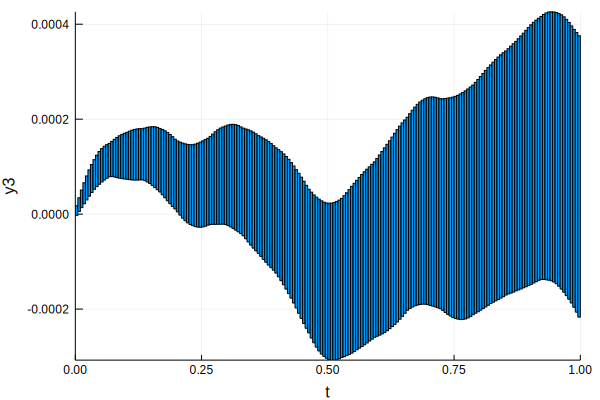

In [47]:
sol = solve(problem_TV, :T=>1.0, :δ=>5e-3, :vars=> 1:270, :plot_vars=>[0, 270],
                        :projection_matrix=>C, :assume_sparse => true);
plot(sol, xlabel="t", ylabel="y3")

Computing successors 100%|██████████████████████████████| Time: 0:00:46


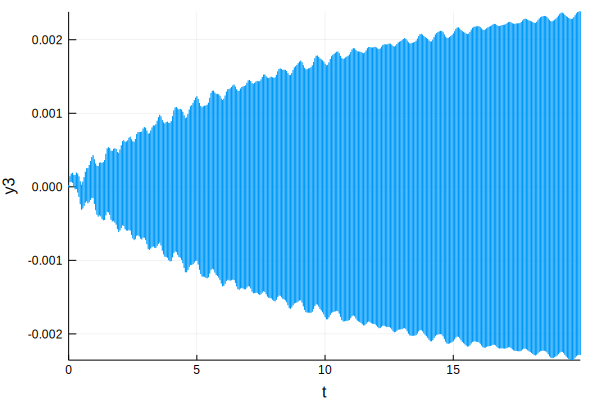

In [49]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>5e-3, :vars=>1:270, :plot_vars=>[0, 270],
                        :projection_matrix=>C, :assume_sparse => true, :verbosity=>0);
plot(sol, xlabel="t", ylabel="y3", indices=1:10:4000)

#### Check mode (dense time) <a id='check-dense-TV'> </a>

For the time-varying case, the specification $y_3 \in [-0.0005, 0.0005]$ should be violated around time ~13.7, whereas the specification $y_3 \in [-0.0007, 0.0007]$ is safe.

In [5]:
y3SPEC1 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0005)), 
                                    Clause(LinearConstraint(-Cvec, 0.0005))])
y3SPEC2 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0007)), 
                                    Clause(LinearConstraint(-Cvec, 0.0007))]);

In [8]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC1,
                        :projection_matrix=>C, :assume_sparse=>true);
sol.satisfied, sol.violation

Computing successors   5%|██                            |  ETA: 0:00:18

(false, 298)

In [9]:
sol = solve(problem_TV, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC2,
                        :projection_matrix=>C, :assume_sparse=>true);
sol.satisfied, sol.violation

Computing successors  10%|███                           |  ETA: 0:00:18

(false, 502)

#### Check mode (discrete time)  <a id='check-discrete-TV'> </a>

In [10]:
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                        :mode=>"check", :property=>y3SPEC1, :projection_matrix=>C, :assume_sparse=>true);
sol.satisfied, sol.violation

Computing successors   8%|██                            |  ETA: 0:00:12

(false, 581)

In [11]:
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                        :mode=>"check", :property=>y3SPEC2, :projection_matrix=>C, :assume_sparse=>true);
sol.satisfied, sol.violation

Computing successors  16%|█████                         |  ETA: 0:00:11

(false, 830)

##### Advaced settings  <a id='Advanced-settings'> </a>

The `:lazy_inputs_interval` option can be used to modify the length of the interval in which the inputs are handled as a lazy set. At a higher cost, the reach set can be more accurate.

The option `:ε` can be used to define a tolerance for the iterative refinement for polygonal overapproximations of the reachset.

The option `:partition` can be used to define custom block sizes for different sets of variables.

In [51]:
# continuous time
sol = solve(problem_TV, :approx_model=>"forward", :T=>time_horizon, :δ=>6e-4, :vars=>136:270,
                        :mode=>"check", :property=>y3SPEC2, :projection_matrix=>C, :assume_sparse=>true,
                        :lazy_inputs_interval=>40000,
                        :partition=>[1:135, 136:270], :verbosity=>1);
sol.satisfied, sol.violation

[info] Time discretization...
[info] elapsed time: 0.411089582 seconds
[info] Property Checking...
[info] - Decomposing X0
[info] elapsed time: 0.04756502 seconds
[info] - Computing successors


Computing successors  92%|████████████████████████████  |  ETA: 0:00:00

[info] elapsed time: 5.412339814 seconds
[info] - Total
[info] elapsed time: 5.461862259 seconds
[info] The property is satisfied!


Computing successors 100%|██████████████████████████████| Time: 0:00:05


(true, -1)

In [39]:
# discrete time
sol = solve(problem_TV, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=>136:270,
                        :mode=>"check", :property=>y3SPEC2, :projection_matrix=>C, :assume_sparse=>true,
                        :lazy_inputs_interval=>4000,
                        :partition=>[1:135, 136:270], :verbosity=>1);
sol.satisfied, sol.violation

[info] Time discretization...
[info] elapsed time: 0.447437945 seconds
[info] Property Checking...
[info] - Decomposing X0
[info] elapsed time: 0.015713364 seconds
[info] - Computing successors
[info] elapsed time: 0.580886229 seconds
[info] - Total
[info] elapsed time: 0.598301021 seconds
[info] The property is satisfied!


(true, -1)

## Constant input <a id='Constant-input'> </a>

In [15]:
import Reachability.add_dimension
A = sparse(read(file, "A"))
Aext = add_dimension(A, 3)
Aext[1:270, 271:273] = B
S = LinearContinuousSystem(Aext);

X0 = X0 * U
problem_CONST = InitialValueProblem(S, X0);
C = hcat(C, [0.0 0.0 0.0])
Cvec = C[1, :]
size(S.A), dim(X0), size(C)

((273, 273), 273, (1, 273))

#### Dense time reachability plots: <a id='dense-reach-plots-CONST'> </a>

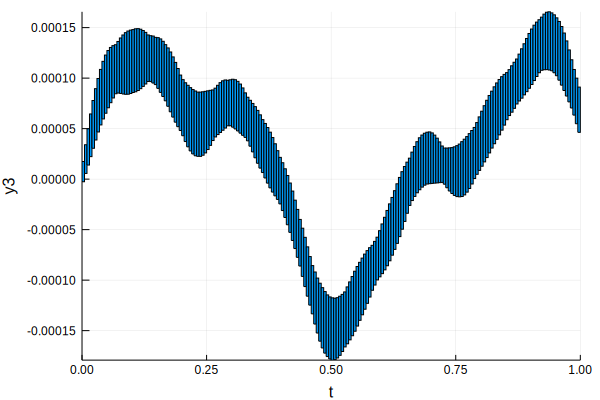

In [20]:
sol = solve(problem_CONST, :T=>1.0, :δ=>5e-3, :vars=>1:273, :plot_vars=>[0, 270],
                           :projection_matrix=>C, :assume_sparse => true);
plot(sol, xlabel="t", ylabel="y3")

Computing successors 100%|██████████████████████████████| Time: 0:00:20


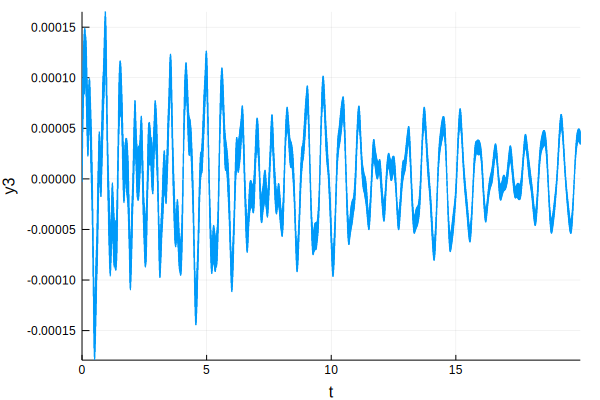

In [23]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>5e-3, :vars=> 1:273, :plot_vars=>[0, 270],
                           :projection_matrix=>C, :assume_sparse=>true);
plot(sol, xlabel="t", ylabel="y3", indices=1:2:4000)

#### Check mode (dense time) <a id='check-dense-CONST'> </a>

In the constant-input case, the specification $y_3 \in [-0.00017, 0.00017]$ is violated around time ~0.5, whereas the specification $y_3 \in [-0.0005, 0.0005]$ is safe.

In [24]:
y3SPEC3 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.00017)), 
                                    Clause(LinearConstraint(-Cvec, 0.00017))])
y3SPEC4 = LinearConstraintProperty([Clause(LinearConstraint(Cvec, 0.0005)), 
                                    Clause(LinearConstraint(-Cvec, 0.0005))]);

In [25]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC3,
                           :projection_matrix=>C, :assume_sparse => true, :assume_homogeneous=>true);
sol.satisfied, sol.violation

(false, 98)

In [26]:
sol = solve(problem_CONST, :T=>time_horizon, :δ=>5e-3, :vars=> 136:270, :mode=>"check", :property=>y3SPEC4,
                           :projection_matrix=>C, :assume_sparse => true, :assume_homogeneous=>true);
sol.satisfied, sol.violation

Computing successors 100%|██████████████████████████████| Time: 0:00:11


(true, -1)

#### Check mode (discrete time) <a id='check-discrete-CONST'> </a>

In [27]:
sol = solve(problem_CONST, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                           :mode=>"check", :property=>y3SPEC3, :projection_matrix=>C,
                           :assume_sparse => true, :assume_homogeneous=>true);
sol.satisfied, sol.violation

(false, 99)

In [28]:
sol = solve(problem_CONST, :approx_model=>"nobloating", :T=>time_horizon, :δ=>5e-3, :vars=> 136:270,
                           :mode=>"check", :property=>y3SPEC4, :projection_matrix=>C,
                           :assume_sparse => true, :assume_homogeneous=>true);
sol.satisfied, sol.violation

Computing successors 100%|██████████████████████████████| Time: 0:00:10


(true, -1)